<a href="https://colab.research.google.com/github/amany-adel/Image-Classification-Cat-and-Dog-/blob/main/CNN_cat_and_dog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import zipfile
from google.colab import drive
import cv2
import random
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Import the Data and unzip it
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# prompt: connect to the tpu

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)


REPLICAS:  1


In [ ]:
#label the train data
drive_directory = '/content/drive/My Drive/Colab Notebooks/Image Recognition  (cat and dog)/Data/train'
label = []
filenames = os.listdir(drive_directory)
for name in os.listdir(drive_directory):
    val = name.split(".")[0]
    if val=="dog":
      label.append('1')
    else:
      label.append('0')
df = pd.DataFrame({
    'filename' : filenames,
    'category' : label
})

df

,filename,category
0,cat.909.jpg,0
1,cat.9097.jpg,0
2,cat.911.jpg,0
3,cat.9075.jpg,0
4,cat.9113.jpg,0
...,...,...
23505,dog.10489.jpg,1
23506,dog.10437.jpg,1
23507,dog.10485.jpg,1
23508,dog.10474.jpg,1


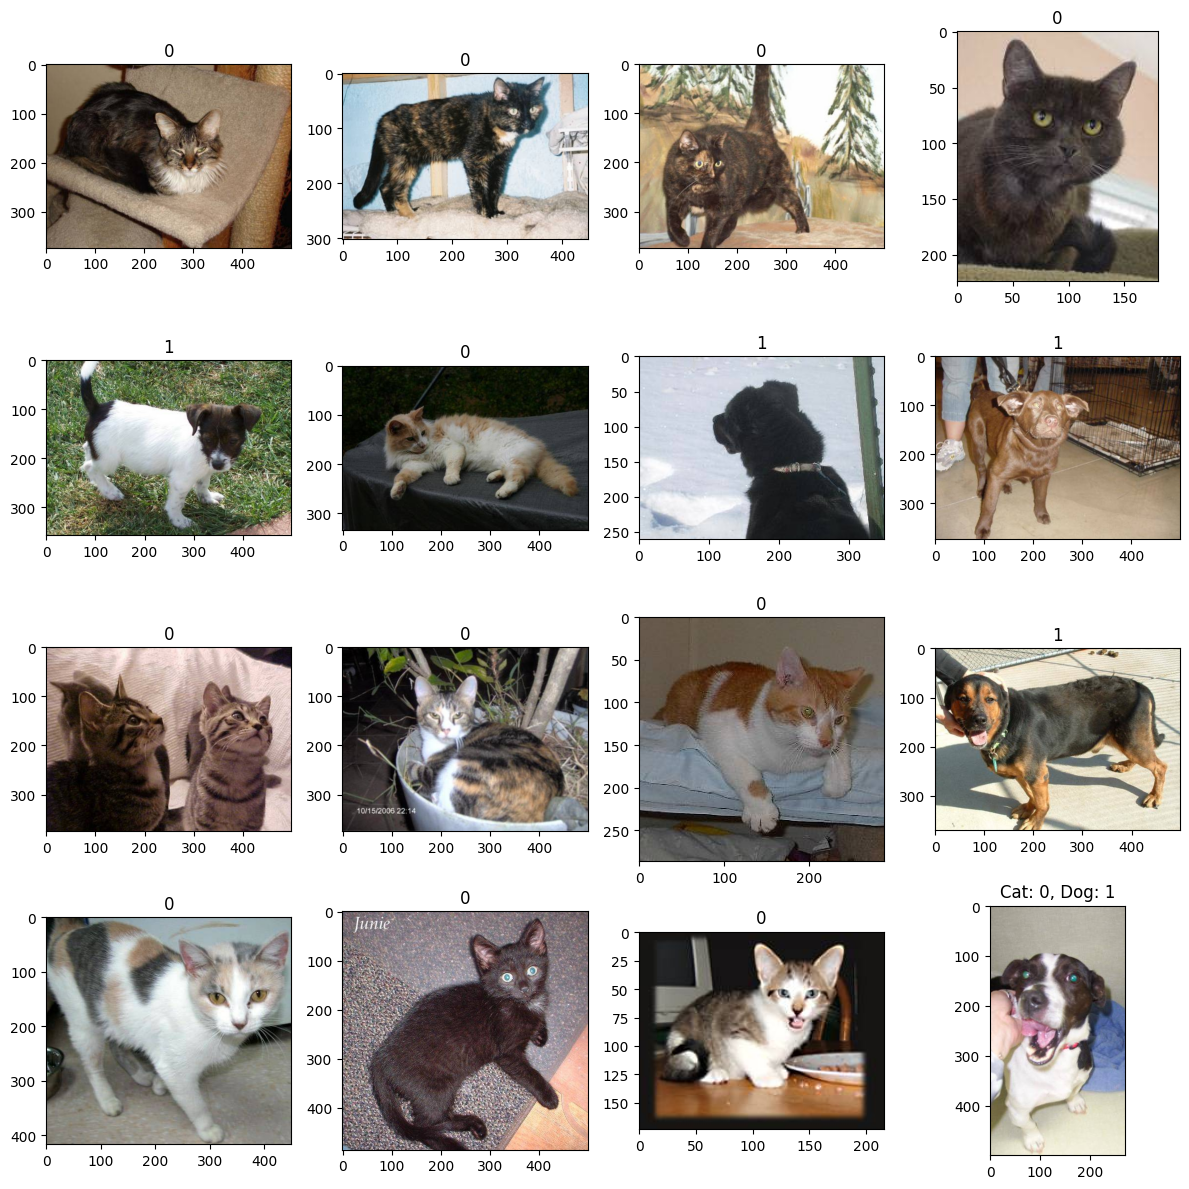

In [ ]:
plt.figure(figsize=(12, 12))
for i in range(0, 16):
    plt.subplot(4, 4, i+1)
    sample = random.choice(filenames)
    name = drive_directory+'/'+sample
    image = imread(name)
    plt.imshow(image)
    title=df.loc[df['filename']==sample,'category'].values[0]
    plt.title(title)
plt.tight_layout()
plt.title("Cat: 0, Dog: 1")
plt.show()

In [ ]:
#prepare validation data
train_data, val_data = train_test_split(df, test_size=0.2, random_state=42)

train_data = train_data.reset_index(drop=True)
val_data = val_data.reset_index(drop=True)
print(train_data.shape)
print(val_data.shape)

(18808, 2)
(4702, 2)


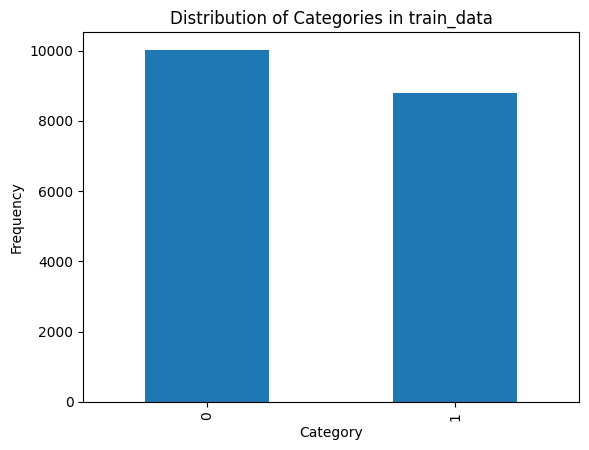

In [ ]:
train_data['category'].value_counts().plot.bar()

plt.xlabel('Category')
plt.ylabel('Frequency')
plt.title('Distribution of Categories in train_data')
plt.show()

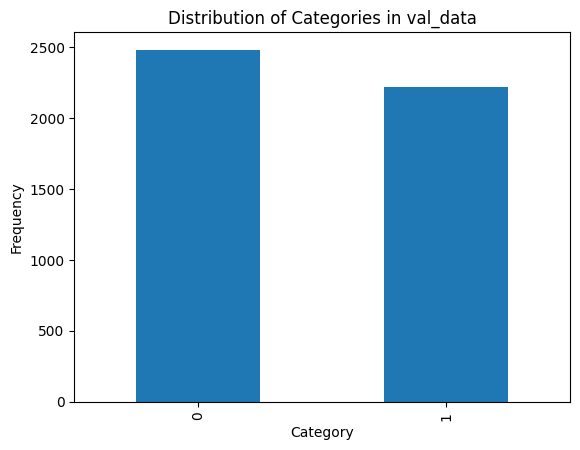

In [ ]:
val_data['category'].value_counts().plot.bar()

plt.xlabel('Category')
plt.ylabel('Frequency')
plt.title('Distribution of Categories in val_data')
plt.show()

In [ ]:
batch_size = 32
epochs = 30
train_size=train_data.shape[0]
val_size=val_data.shape[0]
img_hieght = 128
img_width = 128
img_channels = 3






In [ ]:
# do data augmentation on traindata and validation data
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 15,
    horizontal_flip = True,
    zoom_range = 0.2,
    shear_range = 0.1,
    fill_mode = 'reflect',
    width_shift_range = 0.1,
    height_shift_range = 0.1
)
train_generator = train_datagen.flow_from_dataframe(
    train_data,
    drive_directory,
    x_col = 'filename',
    y_col = 'category',
    target_size = (img_hieght,img_width),
    batch_size = batch_size,
    class_mode = 'binary'
)
val_generator = train_datagen.flow_from_dataframe(
    val_data,
    drive_directory,
    x_col = 'filename',
    y_col = 'category',
    target_size = (img_hieght,img_width),
    batch_size = batch_size,
    class_mode = 'binary'
)

Found 18808 validated image filenames belonging to 2 classes.
Found 4702 validated image filenames belonging to 2 classes.


Found 1 validated image filenames.


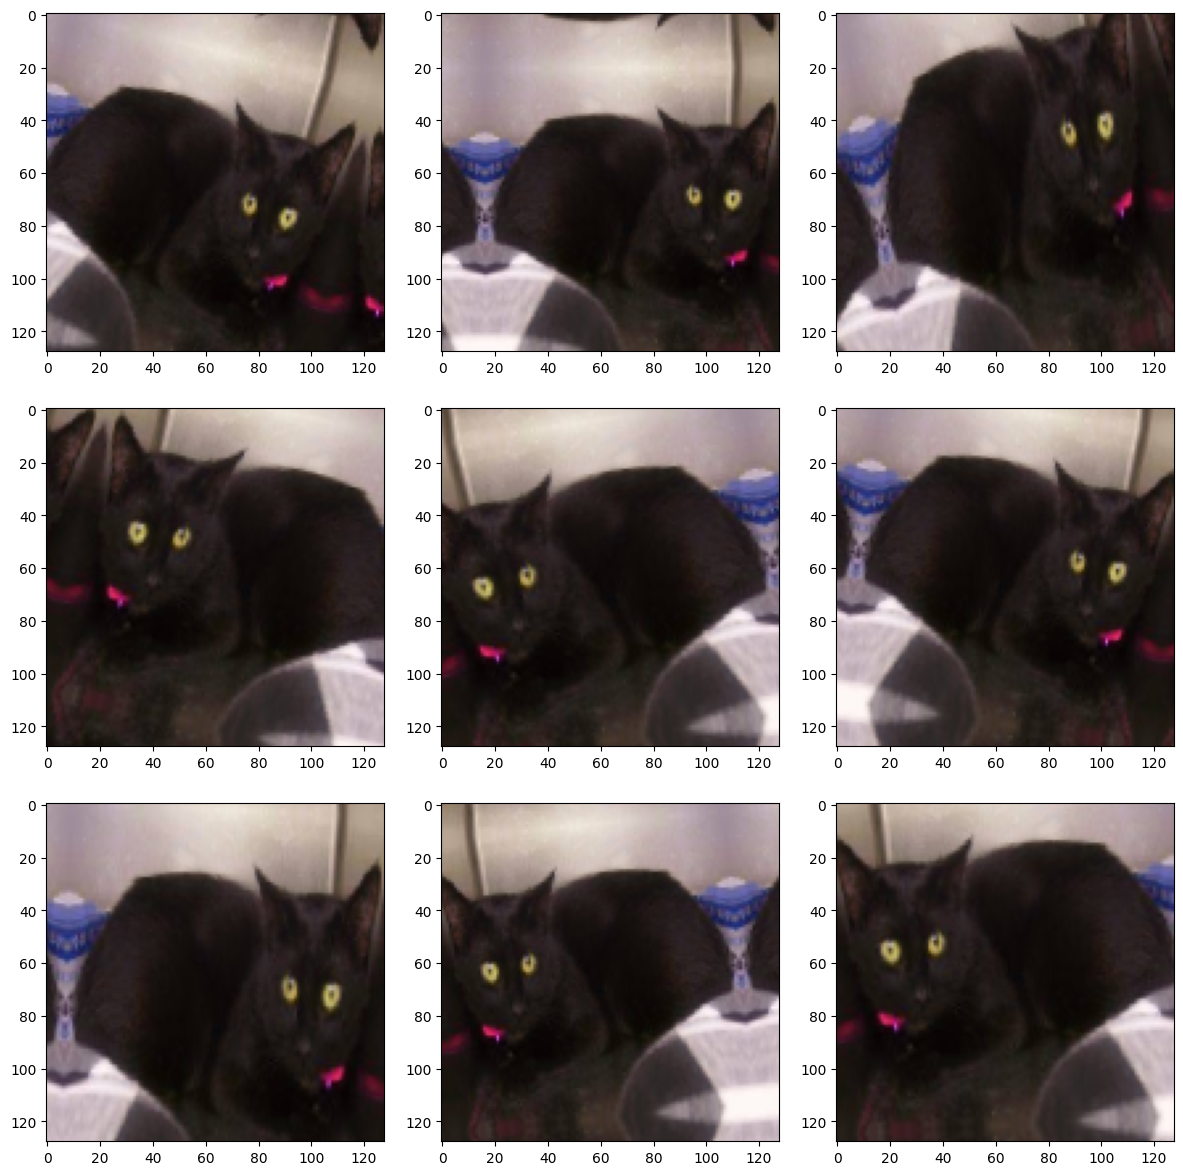

In [ ]:
#show a sample of augmented data
example_df = train_data.sample(n=1)
example_generator = train_datagen.flow_from_dataframe(
    example_df,
    drive_directory,
    x_col='filename',
    y_col='category',
    target_size=(img_hieght,img_width),
    class_mode='raw'
)

plt.figure(figsize=(12, 12))
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [ ]:
model = Sequential()

model.add(Conv2D(32,(3,3),activation='relu',input_shape = (img_hieght,img_width,img_channels)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(256,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(1,activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 126, 126, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 61, 61, 64)        2

In [ ]:
model.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=2,
                                            factor=0.5,
                                            min_lr=0.00001,
                                            verbose=1)
callbacks = [learning_rate_reduction]

In [ ]:
history=model.fit_generator(
    train_generator,
    epochs = epochs,
    validation_data =  val_generator,
    steps_per_epoch = train_size//batch_size,
    validation_steps = val_size//batch_size,
    callbacks = callbacks
)

<ipython-input-15-a111fe4176c8>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(


Epoch 1/30
587/587 [==============================] - 615s 1s/step - loss: 0.6703 - accuracy: 0.6597 - val_loss: 0.6203 - val_accuracy: 0.6732 - lr: 0.0010
Epoch 2/30
587/587 [==============================] - 208s 355ms/step - loss: 0.5316 - accuracy: 0.7351 - val_loss: 0.5486 - val_accuracy: 0.7166 - lr: 0.0010
Epoch 3/30
587/587 [==============================] - 208s 354ms/step - loss: 0.4613 - accuracy: 0.7838 - val_loss: 0.5153 - val_accuracy: 0.7611 - lr: 0.0010
Epoch 4/30
587/587 [==============================] - 206s 352ms/step - loss: 0.4140 - accuracy: 0.8085 - val_loss: 0.4997 - val_accuracy: 0.7622 - lr: 0.0010
Epoch 5/30
587/587 [==============================] - 205s 349ms/step - loss: 0.3805 - accuracy: 0.8282 - val_loss: 0.5223 - val_accuracy: 0.7440 - lr: 0.0010
Epoch 6/30
587/587 [==============================] - 207s 352ms/step - loss: 0.3458 - accuracy: 0.8487 - val_loss: 0.4526 - val_accuracy: 0.7870 - lr: 0.0010
Epoch 7/30
587/587 [=============================